In [ ]:
import numpy as np
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

df = pd.read_csv("train.csv")
df["service_date"] = pd.to_datetime(df["service_date"])
df = df.drop("index", axis=1)
# df = df.set_index("service_date")
df["sum_price"] = df["sum_price"].apply(lambda x: abs(x))


train = df.groupby(["service_date"])["sum_price"].sum()

<Axes: xlabel='service_date'>

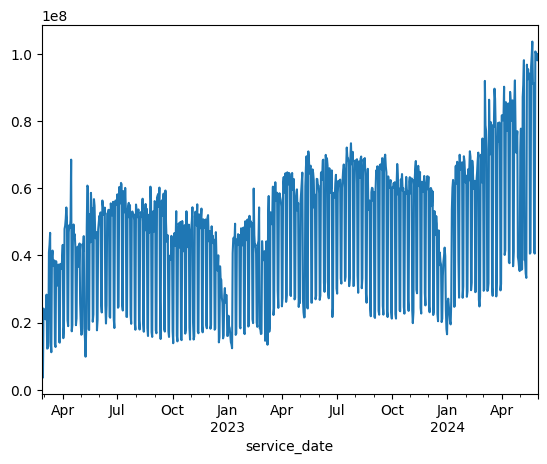

In [ ]:
train_after_covid = train[train.index > "2022-02-24"]
# train_after_covid = train
train_after_covid.plot()

In [ ]:
train_after_covid = train_after_covid.reset_index()
train_after_covid.columns = ["date", "forecast_value"]

In [ ]:
train_after_covid["item_id"] = "H1"

train_after_covid.columns = ["timestamp", "target", "item_id"]

In [ ]:
train_after_covid

,timestamp,target,item_id
0,2022-02-25,2.784901e+07,H1
1,2022-02-26,4.872699e+06,H1
2,2022-02-27,3.604619e+06,H1
3,2022-02-28,2.415991e+07,H1
4,2022-03-01,2.112790e+07,H1
...,...,...,...
822,2024-05-27,1.007527e+08,H1
823,2024-05-28,1.003180e+08,H1
824,2024-05-29,9.832966e+07,H1
825,2024-05-30,1.000403e+08,H1


In [ ]:
train_data = TimeSeriesDataFrame.from_data_frame(
    train_after_covid, id_column="item_id", timestamp_column="timestamp"
)
train_data.head()

target
item_id timestamp               
H1      2022-02-25  2.784901e+07
        2022-02-26  4.872699e+06
        2022-02-27  3.604619e+06
        2022-02-28  2.415991e+07
        2022-03-01  2.112790e+07

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=30,
    path="autogluon-m4-hourly",
    target="target",
    eval_metric="RMSE",
    freq="D",
)

predictor.fit(
    train_data,
    presets="high_quality",
    time_limit=600,
)

Beginning AutoGluon training... Time limit = 600s
AutoGluon will save models to 'autogluon-m4-hourly'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.9.16
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Wed Aug  7 16:19:28 UTC 2024
CPU Count:          16
GPU Count:          1
Memory Avail:       9.62 GB / 15.49 GB (62.1%)
Disk Space Avail:   228.61 GB / 468.09 GB (48.8%)
Setting presets to: high_quality

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'D',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 30,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 600,
 'verbosity': 2}

Provided train_data has 827 rows, 1 time series. Median time seri

model.safetensors:  92%|#########2| 744M/806M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

	-38047990.1171= Validation score (-RMSE)
	0.01    s     = Training runtime
	13.81   s     = Validation (prediction) runtime
Training timeseries model TemporalFusionTransformer. Training for up to 127.0s of the 508.2s of remaining time.
	-15303497.2202= Validation score (-RMSE)
	45.66   s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Training timeseries model DeepAR. Training for up to 154.2s of the 462.5s of remaining time.
	-17541802.6163= Validation score (-RMSE)
	71.76   s     = Training runtime
	0.17    s     = Validation (prediction) runtime
Training timeseries model PatchTST. Training for up to 195.3s of the 390.5s of remaining time.
	-22630861.7150= Validation score (-RMSE)
	16.32   s     = Training runtime
	0.02    s     = Validation (prediction) runtime
Fitting simple weighted ensemble.
	Ensemble weights: {'AutoETS': 0.07, 'DeepAR': 0.27, 'TemporalFusionTransformer': 0.66}
	-14588462.9559= Validation score (-RMSE)
	1.19    s     = Training runtime
	2

In [ ]:
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-1.458846e+07,20.337309,1.192697,13
1,TemporalFusionTransformer,-1.530350e+07,0.017293,45.660393,10
2,DeepAR,-1.754180e+07,0.174538,71.762802,11
3,PatchTST,-2.263086e+07,0.022891,16.322621,12
4,AutoETS,-2.283511e+07,20.145478,0.024345,7
5,DirectTabular,-2.361883e+07,0.070977,1.315050,3
6,DynamicOptimizedTheta,-2.712461e+07,24.100826,0.026848,6
7,AutoARIMA,-2.785293e+07,12.589760,0.019917,8
8,NPTS,-3.229240e+07,1.326962,0.029874,5
9,CrostonSBA,-3.248678e+07,8.367438,0.016711,4


In [ ]:
predictions = predictor.predict(train_data)
predictions.head()

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


mean           0.1           0.2           0.3  \
item_id timestamp                                                            
H1      2024-06-01  4.815145e+07  3.909000e+07  4.263354e+07  4.435978e+07   
        2024-06-02  4.261421e+07  3.693025e+07  3.915861e+07  4.035086e+07   
        2024-06-03  9.939160e+07  9.086597e+07  9.481260e+07  9.671920e+07   
        2024-06-04  9.957963e+07  9.060822e+07  9.506380e+07  9.727252e+07   
        2024-06-05  1.002571e+08  9.127307e+07  9.570447e+07  9.760986e+07   

                             0.4           0.5           0.6           0.7  \
item_id timestamp                                                            
H1      2024-06-01  4.513581e+07  4.808718e+07  5.117546e+07  5.161248e+07   
        2024-06-02  4.123587e+07  4.257373e+07  4.457929e+07  4.554887e+07   
        2024-06-03  9.890828e+07  9.925140e+07  1.014793e+08  1.024161e+08   
        2024-06-04  9.914654e+07  9.968843e+07  1.021588e+08  1.032457e+08   
        2024-06-05  9.946386e+07  1.001911e+08  1.030250e+08  1.042103e+08   

                             0.8           0.9  
item_id timestamp                               
H1      2024-06-01  5.499146e+07  5.652579e+07  
        2024-06-02  4.799328e+07  4.922127e+07  
        2024-06-03  1.038977e+08  1.062843e+08  
        2024-06-04  1.043854e+08  1.071461e+08  
        2024-06-05  1.055682e+08  1.087569e+08

<Axes: xlabel='timestamp'>

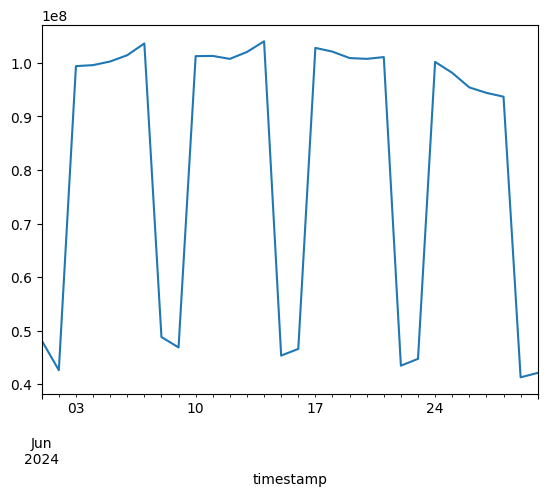

In [ ]:
predictions.reset_index(level=0, drop=True)["mean"].plot()

In [ ]:
submission = pd.read_csv("sample_submission.csv")

submission["forecast_value"] = predictions.reset_index(level=0, drop=True)[
    "mean"
].to_numpy()
submission.to_csv("autogluon600.csv", index=False)